In [1]:
%matplotlib inline

CorrelationRemover visualization
================================


This notebook demonstrates the use of the
`fairlearn.preprocessing.CorrelationRemover`{.interpreted-text
role="func"} class. We will show this by looking at the correlation
matrices of the dataset before and after the CorrelationRemover.

Getting the Data
================



We will use the well-known UCI \'Adult\' dataset as the basis of this
demonstration. This is not for a lending scenario, but we will regard it
as one for the purposes of this example. We will use the existing
\'sex\' column to illustrate how the CorrelationRemover works. 



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from fairlearn.preprocessing import CorrelationRemover

Next, we import the data and transform the \'sex\' column to a binary
feature. We also drop most dummy columns that are created, since we are
looking specifically at the African American race. Finally, the columns
are rearranged for consistency.


In [3]:
data = fetch_openml(data_id=43874, as_frame=True)


In [4]:
data.data.head()

,race,gender,age,discharge_disposition_id,admission_source_id,time_in_hospital,medical_specialty,num_lab_procedures,num_procedures,num_medications,...,insulin,change,diabetesMed,medicare,medicaid,had_emergency,had_inpatient_days,had_outpatient_days,readmitted,readmit_binary
0,Caucasian,Female,30 years or younger,Other,Referral,1.0,Other,41.0,0.0,1.0,...,No,No,No,False,False,False,False,False,NO,0.0
1,Caucasian,Female,30 years or younger,Discharged to Home,Emergency,3.0,Missing,59.0,0.0,18.0,...,Up,Ch,Yes,False,False,False,False,False,>30,1.0
2,AfricanAmerican,Female,30 years or younger,Discharged to Home,Emergency,2.0,Missing,11.0,5.0,13.0,...,No,No,Yes,False,False,False,True,True,NO,0.0
3,Caucasian,Male,30-60 years,Discharged to Home,Emergency,2.0,Missing,44.0,1.0,16.0,...,Up,Ch,Yes,False,False,False,False,False,NO,0.0
4,Caucasian,Male,30-60 years,Discharged to Home,Emergency,1.0,Missing,51.0,0.0,8.0,...,Steady,Ch,Yes,False,False,False,False,False,NO,0.0


In [5]:
X_raw = data.data[["race", "time_in_hospital", "had_inpatient_days", "medicare"]]
X_raw.head()

,race,time_in_hospital,had_inpatient_days,medicare
0,Caucasian,1.0,False,False
1,Caucasian,3.0,False,False
2,AfricanAmerican,2.0,True,False
3,Caucasian,2.0,False,False
4,Caucasian,1.0,False,False


In [6]:
X_raw = pd.get_dummies(X_raw)
X_raw

,time_in_hospital,race_AfricanAmerican,race_Asian,race_Caucasian,race_Hispanic,race_Other,race_Unknown,had_inpatient_days_True,had_inpatient_days_False,medicare_True,medicare_False
0,1.0,0,0,1,0,0,0,0,1,0,1
1,3.0,0,0,1,0,0,0,0,1,0,1
2,2.0,1,0,0,0,0,0,1,0,0,1
3,2.0,0,0,1,0,0,0,0,1,0,1
4,1.0,0,0,1,0,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...
101761,3.0,1,0,0,0,0,0,0,1,1,0
101762,5.0,1,0,0,0,0,0,1,0,1,0
101763,1.0,0,0,1,0,0,0,0,1,1,0
101764,10.0,0,0,1,0,0,0,1,0,1,0


In [7]:

y = data.target

X_raw = X_raw.drop(["race_Asian",
                    'race_Caucasian',
                    'race_Hispanic',
                    'race_Other',
                    'race_Unknown',
                    'had_inpatient_days_False',
                    'medicare_False'], axis=1)

X_raw = X_raw[['time_in_hospital', 'had_inpatient_days_True', 'medicare_True', 'race_AfricanAmerican']]

In [8]:
X_raw

,time_in_hospital,had_inpatient_days_True,medicare_True,race_AfricanAmerican
0,1.0,0,0,0
1,3.0,0,0,0
2,2.0,1,0,1
3,2.0,0,0,0
4,1.0,0,0,0
...,...,...,...,...
101761,3.0,0,1,1
101762,5.0,1,1,1
101763,1.0,0,1,0
101764,10.0,1,1,0


We are now going to fit the CorrelationRemover to the data, and
transform it. The transformed array will be placed back in a Pandas
DataFrame, for plotting purposes.


In [9]:
cr = CorrelationRemover(sensitive_feature_ids=["race_AfricanAmerican"])
X_cr = cr.fit_transform(X_raw)
X_cr = pd.DataFrame(X_cr, columns=['time_in_hospital', 'had_inpatient_days_True', 'medicare_True'])
X_cr["race_AfricanAmerican"] = X_raw["race_AfricanAmerican"]

cr_alpha = CorrelationRemover(sensitive_feature_ids=['race_AfricanAmerican'], alpha=0.5)
X_cr_alpha = cr_alpha.fit_transform(X_raw)
X_cr_alpha = pd.DataFrame(X_cr_alpha, columns=['time_in_hospital', 'had_inpatient_days_True', 'medicare_True'])
X_cr_alpha["race_AfricanAmerican"] = X_raw["race_AfricanAmerican"]

We can now plot the correlation matrices before and after the
CorrelationRemover. [matplotlib
docs](https://matplotlib.org/devdocs/gallery/images_contours_and_fields/image_annotated_heatmap.html).


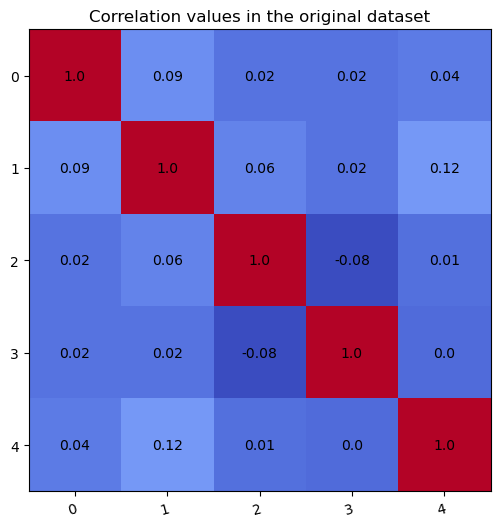

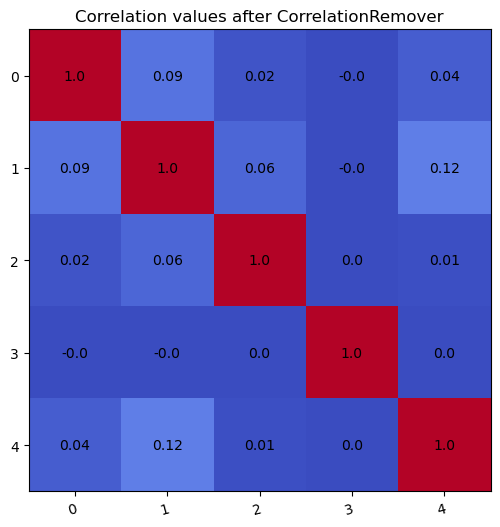

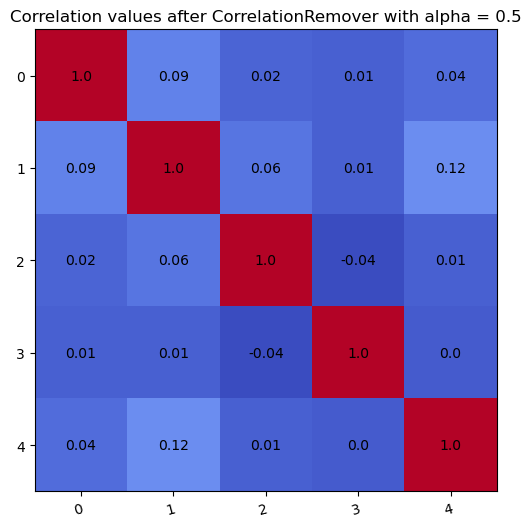

In [12]:
def plot_heatmap(df, title):
    df['target'] = y
    df = df.rename(columns={"had_inpatient_days_True": "had_inpatient_days"})
    cols = list(df.columns)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.imshow(round(df.corr(), 2), cmap="coolwarm")

    # Show all ticks and label them with the respective list entries
    ax.set_xticks(np.arange(len(cols)))
    ax.set_yticks(np.arange(len(cols)))
    #ax.set_xticks(np.arange(len(cols)))
    #ax.set_xtickslabels(cols)
    #ax.set_yticks(np.arange(len(cols)))
    #ax.set_ytickslabels(cols)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=15, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(cols)):
        for j in range(len(cols)):
            ax.text(
                j,
                i,
                round(df.corr().to_numpy()[i, j], 2),
                ha="center",
                va="center",
            )

    ax.set_title(f"{title}")
    plt.show()


plot_heatmap(X_raw, "Correlation values in the original dataset")
plot_heatmap(X_cr, "Correlation values after CorrelationRemover")
plot_heatmap(X_cr_alpha, "Correlation values after CorrelationRemover with alpha = 0.5")

Even though there was not a high amount of correlation to begin with,
the CorrelationRemover successfully removed all correlation between
\'race\_AfricanAmerican\' and the other columns while retaining the
correlation between the other features. Using a lower value of alpha
results in not all the correlation being projected away.
